# GAN 구현하기

In [ ]:
import imageio # 이미지 데이터를 읽고 쓸 수 있는 쉬운 인터페이스 제공
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import matplotlib.pyplot as plt
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
# 변수 값 설정
batch_size = 512
epochs = 200
sample_size = 64  # G에 제공할 노이즈 벡터 크기
nz = 128 # 잠재 벡터 크기 (= G input size)
k = 1 # D의 step 수

In [ ]:
# 정규화
transform = transforms.Compose([
                                transforms.ToTensor(), # 이미지를 텐서로 변환
                                transforms.Normalize((0.5,),(0.5,)), # 평균: 0.5, 표준편차: 0.5
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# 생성자 네트워크
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28) # output: (batch_size, 1, 28, 28)

- Linear layer: 4개
- LeakyReLU 활성화 함수: 3개

In [ ]:
# 판별자 네트워크
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784 # input_size
        self.main = nn.Sequential( # G와 동일한 구조 - 선형 계층, LeakyReLU
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x) # 이미지가 진짜인지(pdata) 가짜인지(pg) 분류

In [ ]:
# 생성자, 판별자 네트워크 초기화
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [ ]:
# 옵티마이저, 손실함수
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] # 생성자 오차 저장
losses_d = [] # 판별자 오차 저장
images = [] # 생성 이미지 저장

In [ ]:
# 생성된 이미지 저장 함수
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# 판별자 학습 함수
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0) # 배치 사이즈
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    # 진짜 데이터
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    # 가짜 데이터
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake # 최종 오차

- real_label, fake_label: 모델 훈련을 위한 진짜 이미지/가짜 이미지와 레이블 정보
  - 크기: (batch_size, 1)
  - 가짜: 0, 진짜: 1

In [ ]:
# 생성자 학습 함수
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device) # 가짜 데이터를 1로 설정
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

- 생성자 학습: 가짜 데이터(G 생성)가 진짜로 분류되기를 원함

In [ ]:
# 모델 학습
generator.train() # 학습 모드
discriminator.train() # 학습 모드

for epoch in range(epochs):
    loss_g = 0.0 # 생성자 오차
    loss_d = 0.0 # 판별자 오차
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k): # k step D training
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach() # G 생성을 위한 노이즈
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake) # D training 종료 → G training
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, "../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx # 총 생성자 오차
    epoch_loss_d = loss_d / idx # 총 판별자 오차
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:11, 10.15it/s]                         

Epoch 0 of 200
Generator loss: 1.40377367, Discriminator loss: 0.87956345



118it [00:12,  9.78it/s]                         


Epoch 1 of 200
Generator loss: 2.21439934, Discriminator loss: 1.39245820


118it [00:12,  9.24it/s]                         

Epoch 2 of 200
Generator loss: 4.04386044, Discriminator loss: 0.71116412



118it [00:15,  7.73it/s]                         

Epoch 3 of 200
Generator loss: 1.27521837, Discriminator loss: 1.39779067



118it [00:13,  8.59it/s]                         


Epoch 4 of 200
Generator loss: 1.71332204, Discriminator loss: 1.26562738


118it [00:13,  8.88it/s]                         

Epoch 5 of 200
Generator loss: 1.07886720, Discriminator loss: 1.28150618



118it [00:13,  8.86it/s]                         


Epoch 6 of 200
Generator loss: 1.31258118, Discriminator loss: 1.19208848


118it [00:12,  9.31it/s]                         

Epoch 7 of 200
Generator loss: 1.58310735, Discriminator loss: 1.29676223



118it [00:11,  9.89it/s]                         

Epoch 8 of 200
Generator loss: 1.65552723, Discriminator loss: 1.29343808



118it [00:13,  8.84it/s]                         

Epoch 9 of 200
Generator loss: 1.10073507, Discriminator loss: 1.23276806



118it [00:13,  8.43it/s]                         

Epoch 10 of 200
Generator loss: 1.37186325, Discriminator loss: 1.11243701



118it [00:11, 10.64it/s]                         


Epoch 11 of 200
Generator loss: 2.32905841, Discriminator loss: 1.22687173


118it [00:14,  8.19it/s]                         

Epoch 12 of 200
Generator loss: 3.83429551, Discriminator loss: 0.86040270



118it [00:14,  8.04it/s]                         

Epoch 13 of 200
Generator loss: 2.64244390, Discriminator loss: 1.00241637



118it [00:14,  8.15it/s]                         

Epoch 14 of 200
Generator loss: 1.57207346, Discriminator loss: 0.82796770



118it [00:12,  9.20it/s]                         

Epoch 15 of 200
Generator loss: 2.34277415, Discriminator loss: 0.76829785



118it [00:12,  9.20it/s]                         

Epoch 16 of 200
Generator loss: 2.04076672, Discriminator loss: 0.71257138



118it [00:12,  9.59it/s]                         

Epoch 17 of 200
Generator loss: 2.13247371, Discriminator loss: 0.73985845



118it [00:13,  8.48it/s]


Epoch 18 of 200
Generator loss: 2.19349313, Discriminator loss: 0.77749741


118it [00:13,  9.01it/s]                         

Epoch 19 of 200
Generator loss: 1.91561174, Discriminator loss: 0.84439313



118it [00:12,  9.28it/s]                         

Epoch 20 of 200
Generator loss: 2.36011410, Discriminator loss: 0.65063161



118it [00:13,  8.83it/s]                         

Epoch 21 of 200
Generator loss: 2.94536901, Discriminator loss: 0.54952991



118it [00:14,  8.21it/s]                         


Epoch 22 of 200
Generator loss: 2.35631800, Discriminator loss: 0.63046187


118it [00:13,  8.87it/s]                         

Epoch 23 of 200
Generator loss: 2.17176127, Discriminator loss: 0.63063002



118it [00:12,  9.22it/s]                         

Epoch 24 of 200
Generator loss: 2.85167003, Discriminator loss: 0.45388517



118it [00:13,  8.46it/s]                         

Epoch 25 of 200
Generator loss: 3.50829458, Discriminator loss: 0.46889552



118it [00:12,  9.13it/s]                         

Epoch 26 of 200
Generator loss: 2.87557268, Discriminator loss: 0.51540941



118it [00:12,  9.19it/s]                         


Epoch 27 of 200
Generator loss: 3.14299631, Discriminator loss: 0.42407882


118it [00:13,  8.76it/s]

Epoch 28 of 200
Generator loss: 3.10409045, Discriminator loss: 0.47917229



118it [00:12,  9.79it/s]                         

Epoch 29 of 200
Generator loss: 3.01175690, Discriminator loss: 0.43959764



118it [00:11,  9.90it/s]                         

Epoch 30 of 200
Generator loss: 3.07554531, Discriminator loss: 0.44646880



118it [00:12,  9.72it/s]                         

Epoch 31 of 200
Generator loss: 3.02953720, Discriminator loss: 0.50849861



118it [00:11, 10.24it/s]


Epoch 32 of 200
Generator loss: 3.15515327, Discriminator loss: 0.51889747


118it [00:12,  9.36it/s]


Epoch 33 of 200
Generator loss: 3.38957500, Discriminator loss: 0.45850810


118it [00:12,  9.43it/s]                         

Epoch 34 of 200
Generator loss: 3.06595969, Discriminator loss: 0.46617457



118it [00:11, 10.27it/s]                         

Epoch 35 of 200
Generator loss: 3.11752677, Discriminator loss: 0.43671212



118it [00:11, 10.04it/s]                         

Epoch 36 of 200
Generator loss: 3.25220847, Discriminator loss: 0.41671750



118it [00:12,  9.51it/s]                         


Epoch 37 of 200
Generator loss: 3.37569714, Discriminator loss: 0.42419341


118it [00:14,  8.27it/s]                         

Epoch 38 of 200
Generator loss: 3.10961151, Discriminator loss: 0.45419365



118it [00:13,  8.56it/s]                         

Epoch 39 of 200
Generator loss: 3.23402476, Discriminator loss: 0.44030735



118it [00:12,  9.09it/s]                         

Epoch 40 of 200
Generator loss: 3.45728016, Discriminator loss: 0.41420299



118it [00:14,  8.03it/s]                         

Epoch 41 of 200
Generator loss: 3.15640354, Discriminator loss: 0.50636321



118it [00:13,  9.07it/s]                         


Epoch 42 of 200
Generator loss: 3.07002306, Discriminator loss: 0.47908321


118it [00:12,  9.11it/s]                         

Epoch 43 of 200
Generator loss: 3.22725177, Discriminator loss: 0.41000521



118it [00:12,  9.36it/s]                         

Epoch 44 of 200
Generator loss: 3.12018061, Discriminator loss: 0.51946193



118it [00:13,  8.53it/s]                         

Epoch 45 of 200
Generator loss: 2.95476604, Discriminator loss: 0.52382529



118it [00:13,  8.91it/s]                         

Epoch 46 of 200
Generator loss: 3.02824736, Discriminator loss: 0.46052784



118it [00:14,  8.13it/s]                         

Epoch 47 of 200
Generator loss: 3.02147889, Discriminator loss: 0.50762004



118it [00:15,  7.67it/s]                         

Epoch 48 of 200
Generator loss: 2.84183311, Discriminator loss: 0.54165798



118it [00:13,  8.70it/s]

Epoch 49 of 200
Generator loss: 2.83646989, Discriminator loss: 0.52282739



118it [00:13,  8.87it/s]                         

Epoch 50 of 200
Generator loss: 3.26452565, Discriminator loss: 0.41780978



118it [00:12,  9.67it/s]                         

Epoch 51 of 200
Generator loss: 2.99943066, Discriminator loss: 0.54463559



118it [00:13,  8.93it/s]                         

Epoch 52 of 200
Generator loss: 2.86561084, Discriminator loss: 0.56336290



118it [00:12,  9.56it/s]                         

Epoch 53 of 200
Generator loss: 2.82105732, Discriminator loss: 0.49782854



118it [00:13,  9.00it/s]                         

Epoch 54 of 200
Generator loss: 3.12699199, Discriminator loss: 0.42712009



118it [00:12,  9.77it/s]                         

Epoch 55 of 200
Generator loss: 2.90269256, Discriminator loss: 0.50315565



118it [00:11,  9.83it/s]                         

Epoch 56 of 200
Generator loss: 2.70131183, Discriminator loss: 0.55203640



118it [00:11, 10.06it/s]                         


Epoch 57 of 200
Generator loss: 2.68836999, Discriminator loss: 0.54972136


118it [00:11,  9.89it/s]                         

Epoch 58 of 200
Generator loss: 2.64043713, Discriminator loss: 0.53474969



118it [00:11, 10.04it/s]                         

Epoch 59 of 200
Generator loss: 2.81835628, Discriminator loss: 0.55171329



118it [00:12,  9.15it/s]                         

Epoch 60 of 200
Generator loss: 2.76571846, Discriminator loss: 0.55114841



118it [00:11, 10.06it/s]                         

Epoch 61 of 200
Generator loss: 2.86641407, Discriminator loss: 0.48058823



118it [00:11,  9.88it/s]                         

Epoch 62 of 200
Generator loss: 2.86318302, Discriminator loss: 0.49375951



118it [00:12,  9.57it/s]                         

Epoch 63 of 200
Generator loss: 2.79770851, Discriminator loss: 0.53597391



118it [00:12,  9.66it/s]                         

Epoch 64 of 200
Generator loss: 2.66065598, Discriminator loss: 0.57044458



118it [00:12,  9.49it/s]                         

Epoch 65 of 200
Generator loss: 2.68090129, Discriminator loss: 0.59859759



118it [00:12,  9.68it/s]                         

Epoch 66 of 200
Generator loss: 2.57528734, Discriminator loss: 0.56970251



118it [00:12,  9.76it/s]                         

Epoch 67 of 200
Generator loss: 2.59784865, Discriminator loss: 0.54495722



118it [00:13,  8.88it/s]                         

Epoch 68 of 200
Generator loss: 2.58669615, Discriminator loss: 0.60452765



118it [00:12,  9.69it/s]                         

Epoch 69 of 200
Generator loss: 2.51034093, Discriminator loss: 0.63464338



118it [00:12,  9.54it/s]                         

Epoch 70 of 200
Generator loss: 2.51928329, Discriminator loss: 0.61753339



118it [00:12,  9.72it/s]                         

Epoch 71 of 200
Generator loss: 2.49962020, Discriminator loss: 0.64133829



118it [00:12,  9.66it/s]                         

Epoch 72 of 200
Generator loss: 2.41142344, Discriminator loss: 0.66992611



118it [00:12,  9.50it/s]                         

Epoch 73 of 200
Generator loss: 2.48793244, Discriminator loss: 0.63163179



118it [00:12,  9.68it/s]                         

Epoch 74 of 200
Generator loss: 2.38640475, Discriminator loss: 0.61943072



118it [00:12,  9.65it/s]                         

Epoch 75 of 200
Generator loss: 2.46417141, Discriminator loss: 0.58929390



118it [00:12,  9.47it/s]                         

Epoch 76 of 200
Generator loss: 2.49490905, Discriminator loss: 0.60239595



118it [00:12,  9.73it/s]                         

Epoch 77 of 200
Generator loss: 2.49488020, Discriminator loss: 0.65904772



118it [00:12,  9.72it/s]                         

Epoch 78 of 200
Generator loss: 2.23989987, Discriminator loss: 0.73526394



118it [00:11,  9.93it/s]                         

Epoch 79 of 200
Generator loss: 2.20909381, Discriminator loss: 0.69626975



118it [00:12,  9.82it/s]                         

Epoch 80 of 200
Generator loss: 2.27198601, Discriminator loss: 0.69161659



118it [00:11,  9.86it/s]                         

Epoch 81 of 200
Generator loss: 2.28840494, Discriminator loss: 0.69237471



118it [00:11,  9.92it/s]                         

Epoch 82 of 200
Generator loss: 2.15337038, Discriminator loss: 0.71786529



118it [00:13,  9.05it/s]                         

Epoch 83 of 200
Generator loss: 2.17009807, Discriminator loss: 0.73703700



118it [00:11,  9.94it/s]                         

Epoch 84 of 200
Generator loss: 2.13934708, Discriminator loss: 0.70589691



118it [00:12,  9.83it/s]                         

Epoch 85 of 200
Generator loss: 2.21837926, Discriminator loss: 0.72081500



118it [00:11, 10.19it/s]                         


Epoch 86 of 200
Generator loss: 2.13096881, Discriminator loss: 0.74665314


118it [00:11, 10.68it/s]                         


Epoch 87 of 200
Generator loss: 2.15045905, Discriminator loss: 0.72207588


118it [00:11, 10.19it/s]                         

Epoch 88 of 200
Generator loss: 2.09293437, Discriminator loss: 0.74727678



118it [00:11,  9.85it/s]                         

Epoch 89 of 200
Generator loss: 2.11758065, Discriminator loss: 0.73709869



118it [00:12,  9.43it/s]

Epoch 90 of 200
Generator loss: 2.15107298, Discriminator loss: 0.72858858



118it [00:12,  9.61it/s]                         

Epoch 91 of 200
Generator loss: 2.04246855, Discriminator loss: 0.76258808



118it [00:12,  9.62it/s]                         

Epoch 92 of 200
Generator loss: 1.99120605, Discriminator loss: 0.80359757



118it [00:12,  9.57it/s]                         

Epoch 93 of 200
Generator loss: 2.00455809, Discriminator loss: 0.78078932



118it [00:12,  9.64it/s]                         

Epoch 94 of 200
Generator loss: 2.02814293, Discriminator loss: 0.78285950



118it [00:12,  9.47it/s]                         

Epoch 95 of 200
Generator loss: 2.02063608, Discriminator loss: 0.79205352



118it [00:12,  9.43it/s]                         

Epoch 96 of 200
Generator loss: 1.90675783, Discriminator loss: 0.80076057



118it [00:13,  8.73it/s]


Epoch 97 of 200
Generator loss: 1.97846615, Discriminator loss: 0.79313219


118it [00:12,  9.55it/s]                         

Epoch 98 of 200
Generator loss: 1.98483706, Discriminator loss: 0.79081565



118it [00:12,  9.53it/s]                         

Epoch 99 of 200
Generator loss: 2.05477476, Discriminator loss: 0.79189026



118it [00:12,  9.52it/s]                         

Epoch 100 of 200
Generator loss: 1.91293216, Discriminator loss: 0.80028445



118it [00:12,  9.60it/s]

Epoch 101 of 200
Generator loss: 2.01124573, Discriminator loss: 0.76448631



118it [00:12,  9.47it/s]                         

Epoch 102 of 200
Generator loss: 1.96376717, Discriminator loss: 0.81539565



118it [00:12,  9.51it/s]                         

Epoch 103 of 200
Generator loss: 1.90114200, Discriminator loss: 0.82612997



118it [00:12,  9.58it/s]                         

Epoch 104 of 200
Generator loss: 1.87248349, Discriminator loss: 0.84386688



118it [00:12,  9.28it/s]                         

Epoch 105 of 200
Generator loss: 1.83252668, Discriminator loss: 0.83631736



118it [00:12,  9.50it/s]                         

Epoch 106 of 200
Generator loss: 1.84540963, Discriminator loss: 0.84410280



118it [00:12,  9.30it/s]                         

Epoch 107 of 200
Generator loss: 1.86834240, Discriminator loss: 0.83701736



118it [00:12,  9.48it/s]                         

Epoch 108 of 200
Generator loss: 1.81653452, Discriminator loss: 0.83554739



118it [00:13,  9.01it/s]                         

Epoch 109 of 200
Generator loss: 1.83000863, Discriminator loss: 0.83998090



118it [00:14,  8.23it/s]                         

Epoch 110 of 200
Generator loss: 1.84567273, Discriminator loss: 0.82888722



118it [00:17,  6.91it/s]

Epoch 111 of 200
Generator loss: 1.80984724, Discriminator loss: 0.85756552



118it [00:13,  9.06it/s]                         

Epoch 112 of 200
Generator loss: 1.70163465, Discriminator loss: 0.87517685



118it [00:14,  8.40it/s]                         

Epoch 113 of 200
Generator loss: 1.73381114, Discriminator loss: 0.87965101



118it [00:12,  9.13it/s]                         


Epoch 114 of 200
Generator loss: 1.83887172, Discriminator loss: 0.86415076


118it [00:13,  8.63it/s]                         

Epoch 115 of 200
Generator loss: 1.73592865, Discriminator loss: 0.86235958



118it [00:13,  9.03it/s]                         

Epoch 116 of 200
Generator loss: 1.77397060, Discriminator loss: 0.86104357



118it [00:12,  9.30it/s]                         

Epoch 117 of 200
Generator loss: 1.72599745, Discriminator loss: 0.90199071



118it [00:14,  8.14it/s]                         

Epoch 118 of 200
Generator loss: 1.78738117, Discriminator loss: 0.86081427



118it [00:15,  7.85it/s]                         


Epoch 119 of 200
Generator loss: 1.79726768, Discriminator loss: 0.86018628


118it [00:14,  8.28it/s]

Epoch 120 of 200
Generator loss: 1.72970259, Discriminator loss: 0.88119155



118it [00:14,  8.20it/s]                         

Epoch 121 of 200
Generator loss: 1.72693849, Discriminator loss: 0.89979857



118it [00:14,  8.23it/s]                         

Epoch 122 of 200
Generator loss: 1.66841340, Discriminator loss: 0.91005009



118it [00:14,  8.13it/s]                         

Epoch 123 of 200
Generator loss: 1.68753374, Discriminator loss: 0.90700090



118it [00:15,  7.62it/s]                         

Epoch 124 of 200
Generator loss: 1.67499006, Discriminator loss: 0.92482090



118it [00:13,  8.64it/s]                         

Epoch 125 of 200
Generator loss: 1.72846532, Discriminator loss: 0.89358640



118it [00:14,  8.28it/s]                         

Epoch 126 of 200
Generator loss: 1.67392838, Discriminator loss: 0.90853715



118it [00:15,  7.77it/s]                         

Epoch 127 of 200
Generator loss: 1.64327693, Discriminator loss: 0.93770611



118it [00:12,  9.33it/s]


Epoch 128 of 200
Generator loss: 1.65547943, Discriminator loss: 0.91572136


118it [00:12,  9.17it/s]                         

Epoch 129 of 200
Generator loss: 1.65139818, Discriminator loss: 0.93141216



118it [00:13,  9.07it/s]                         

Epoch 130 of 200
Generator loss: 1.64831376, Discriminator loss: 0.92700726



118it [00:12,  9.17it/s]                         


Epoch 131 of 200
Generator loss: 1.68516874, Discriminator loss: 0.91494507


118it [00:13,  8.96it/s]                         

Epoch 132 of 200
Generator loss: 1.68346584, Discriminator loss: 0.90932041



118it [00:12,  9.34it/s]                         

Epoch 133 of 200
Generator loss: 1.61564350, Discriminator loss: 0.94006526



118it [00:12,  9.50it/s]                         

Epoch 134 of 200
Generator loss: 1.66857934, Discriminator loss: 0.90570807



118it [00:12,  9.49it/s]                         

Epoch 135 of 200
Generator loss: 1.68262410, Discriminator loss: 0.92885470



118it [00:12,  9.34it/s]                         


Epoch 136 of 200
Generator loss: 1.63926601, Discriminator loss: 0.94143277


118it [00:13,  8.81it/s]                         

Epoch 137 of 200
Generator loss: 1.58651006, Discriminator loss: 0.93900681



118it [00:12,  9.09it/s]                         

Epoch 138 of 200
Generator loss: 1.61002994, Discriminator loss: 0.93159229



118it [00:12,  9.38it/s]                         

Epoch 139 of 200
Generator loss: 1.58420002, Discriminator loss: 0.95632923



118it [00:12,  9.21it/s]                         


Epoch 140 of 200
Generator loss: 1.54111111, Discriminator loss: 0.95971727


118it [00:12,  9.32it/s]                         


Epoch 141 of 200
Generator loss: 1.56326449, Discriminator loss: 0.95476437


118it [00:12,  9.32it/s]                         

Epoch 142 of 200
Generator loss: 1.49964535, Discriminator loss: 0.98803329



118it [00:12,  9.27it/s]                         

Epoch 143 of 200
Generator loss: 1.49755764, Discriminator loss: 0.97451645



118it [00:12,  9.29it/s]                         

Epoch 144 of 200
Generator loss: 1.54887557, Discriminator loss: 0.95588827



118it [00:12,  9.33it/s]                         

Epoch 145 of 200
Generator loss: 1.57954574, Discriminator loss: 0.95161164



118it [00:12,  9.53it/s]                         


Epoch 146 of 200
Generator loss: 1.58768463, Discriminator loss: 0.96233726


118it [00:12,  9.39it/s]                         

Epoch 147 of 200
Generator loss: 1.53242552, Discriminator loss: 0.95588386



118it [00:12,  9.50it/s]                         

Epoch 148 of 200
Generator loss: 1.57931983, Discriminator loss: 0.95292288



118it [00:12,  9.35it/s]                         

Epoch 149 of 200
Generator loss: 1.57952106, Discriminator loss: 0.94476587



118it [00:12,  9.35it/s]                         

Epoch 150 of 200
Generator loss: 1.55673921, Discriminator loss: 0.96284789



118it [00:11, 10.11it/s]                         

Epoch 151 of 200
Generator loss: 1.53170609, Discriminator loss: 0.96760428



118it [00:12,  9.20it/s]                         

Epoch 152 of 200
Generator loss: 1.53925681, Discriminator loss: 0.95983791



118it [00:11, 10.11it/s]                         

Epoch 153 of 200
Generator loss: 1.50176239, Discriminator loss: 0.98545414



118it [00:11, 10.28it/s]


Epoch 154 of 200
Generator loss: 1.50758922, Discriminator loss: 0.98247331


118it [00:11, 10.56it/s]                         

Epoch 155 of 200
Generator loss: 1.47791445, Discriminator loss: 0.99149919



118it [00:11, 10.47it/s]                         

Epoch 156 of 200
Generator loss: 1.52052736, Discriminator loss: 0.98330313



118it [00:12,  9.68it/s]                         

Epoch 157 of 200
Generator loss: 1.48738801, Discriminator loss: 0.99529558



118it [00:12,  9.82it/s]                         

Epoch 158 of 200
Generator loss: 1.45944083, Discriminator loss: 1.01726639



118it [00:12,  9.63it/s]                         

Epoch 159 of 200
Generator loss: 1.42793703, Discriminator loss: 1.02281106



118it [00:12,  9.22it/s]                         


Epoch 160 of 200
Generator loss: 1.43481016, Discriminator loss: 1.00426543


118it [00:12,  9.60it/s]                         

Epoch 161 of 200
Generator loss: 1.43348455, Discriminator loss: 1.01604795



118it [00:12,  9.64it/s]                         

Epoch 162 of 200
Generator loss: 1.43388546, Discriminator loss: 1.00123918



118it [00:12,  9.79it/s]                         

Epoch 163 of 200
Generator loss: 1.46715117, Discriminator loss: 1.00684071



118it [00:11,  9.86it/s]                         

Epoch 164 of 200
Generator loss: 1.42131937, Discriminator loss: 1.01027882



118it [00:12,  9.76it/s]                         

Epoch 165 of 200
Generator loss: 1.39550030, Discriminator loss: 1.03558588



118it [00:12,  9.81it/s]                         

Epoch 166 of 200
Generator loss: 1.43413043, Discriminator loss: 1.00599587



118it [00:13,  8.97it/s]                         

Epoch 167 of 200
Generator loss: 1.41761482, Discriminator loss: 1.00871885



118it [00:12,  9.77it/s]                         


Epoch 168 of 200
Generator loss: 1.39293301, Discriminator loss: 1.04491150


118it [00:12,  9.78it/s]                         

Epoch 169 of 200
Generator loss: 1.37476122, Discriminator loss: 1.04063702



118it [00:12,  9.76it/s]                         

Epoch 170 of 200
Generator loss: 1.35911226, Discriminator loss: 1.03314173



118it [00:12,  9.67it/s]                         


Epoch 171 of 200
Generator loss: 1.34181035, Discriminator loss: 1.04422212


118it [00:12,  9.81it/s]                         

Epoch 172 of 200
Generator loss: 1.36529326, Discriminator loss: 1.04292488



118it [00:12,  9.77it/s]                         

Epoch 173 of 200
Generator loss: 1.33076370, Discriminator loss: 1.06315041



118it [00:11,  9.87it/s]                         

Epoch 174 of 200
Generator loss: 1.30367529, Discriminator loss: 1.07713389



118it [00:12,  9.73it/s]                         

Epoch 175 of 200
Generator loss: 1.36306870, Discriminator loss: 1.05393255



118it [00:12,  9.78it/s]                         

Epoch 176 of 200
Generator loss: 1.34865749, Discriminator loss: 1.04460156



118it [00:12,  9.68it/s]                         

Epoch 177 of 200
Generator loss: 1.33020365, Discriminator loss: 1.05194211



118it [00:12,  9.80it/s]                         

Epoch 178 of 200
Generator loss: 1.35743976, Discriminator loss: 1.03930879



118it [00:12,  9.68it/s]                         

Epoch 179 of 200
Generator loss: 1.34304440, Discriminator loss: 1.05411673



118it [00:12,  9.60it/s]                         

Epoch 180 of 200
Generator loss: 1.37293553, Discriminator loss: 1.05546284



118it [00:11, 10.01it/s]                         

Epoch 181 of 200
Generator loss: 1.34918308, Discriminator loss: 1.05500746



118it [00:12,  9.08it/s]                         

Epoch 182 of 200
Generator loss: 1.29444802, Discriminator loss: 1.06804967



118it [00:11, 10.12it/s]                         

Epoch 183 of 200
Generator loss: 1.30777907, Discriminator loss: 1.06669271



118it [00:11, 10.03it/s]                         

Epoch 184 of 200
Generator loss: 1.33095253, Discriminator loss: 1.06330800



118it [00:12,  9.83it/s]                         

Epoch 185 of 200
Generator loss: 1.32853687, Discriminator loss: 1.06314814



118it [00:11, 10.06it/s]                         

Epoch 186 of 200
Generator loss: 1.34754848, Discriminator loss: 1.05905545



118it [00:11,  9.92it/s]                         

Epoch 187 of 200
Generator loss: 1.38782680, Discriminator loss: 1.04053056



118it [00:12,  9.81it/s]                         


Epoch 188 of 200
Generator loss: 1.30032563, Discriminator loss: 1.06479430


118it [00:11,  9.86it/s]                         

Epoch 189 of 200
Generator loss: 1.32483912, Discriminator loss: 1.05918038



118it [00:12,  9.78it/s]                         

Epoch 190 of 200
Generator loss: 1.28302610, Discriminator loss: 1.08335710



118it [00:11,  9.84it/s]                         

Epoch 191 of 200
Generator loss: 1.27338707, Discriminator loss: 1.07368433



118it [00:12,  9.72it/s]                         

Epoch 192 of 200
Generator loss: 1.27824640, Discriminator loss: 1.08520985



118it [00:11,  9.89it/s]                         


Epoch 193 of 200
Generator loss: 1.29514301, Discriminator loss: 1.06787026


118it [00:12,  9.81it/s]                         

Epoch 194 of 200
Generator loss: 1.27602613, Discriminator loss: 1.08798087



118it [00:11,  9.92it/s]                         

Epoch 195 of 200
Generator loss: 1.33149707, Discriminator loss: 1.06865430



118it [00:11,  9.95it/s]                         

Epoch 196 of 200
Generator loss: 1.30670798, Discriminator loss: 1.06494188



118it [00:12,  9.27it/s]                         


Epoch 197 of 200
Generator loss: 1.34565783, Discriminator loss: 1.05489838


118it [00:11, 10.25it/s]                         

Epoch 198 of 200
Generator loss: 1.31921148, Discriminator loss: 1.05894053



118it [00:11, 10.32it/s]                         

Epoch 199 of 200
Generator loss: 1.32335162, Discriminator loss: 1.07898080


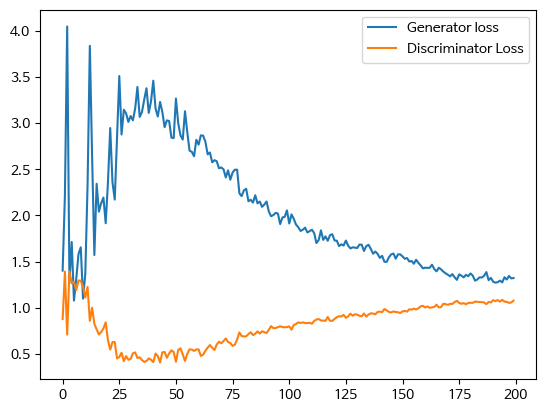

In [ ]:
# 오차 확인
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

- 학습 초기
  - 생성자: 증가
  - 판별자: 감소

  => 학습 초기 단계에 생성자는 좋은 가짜 이미지를 생성하지 못해 쉽게 구분할 수 있기 때문
- 학습 진행
  - 생성자: 진짜와 같은 가짜 이미지 생성(오차 감소)
  - 판별자: 가짜 이미지 중 일부를 진짜로 분류(오차 증가)

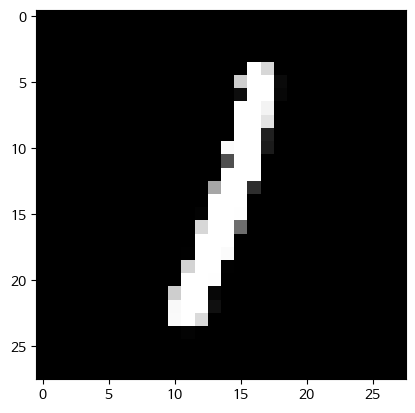

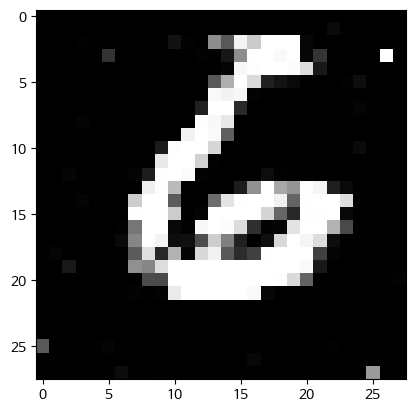

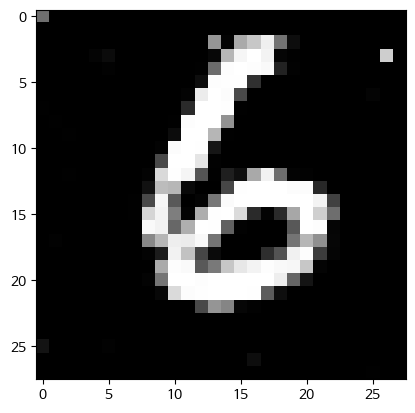

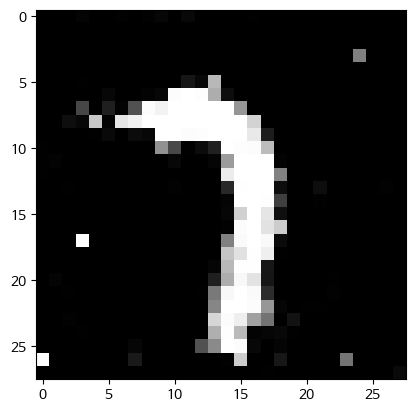

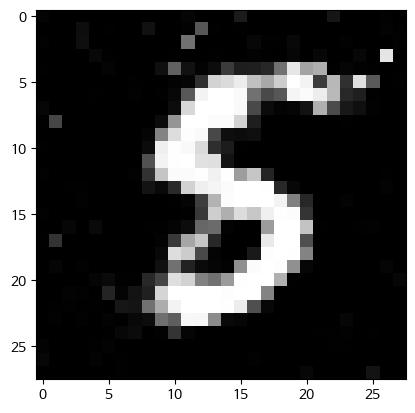

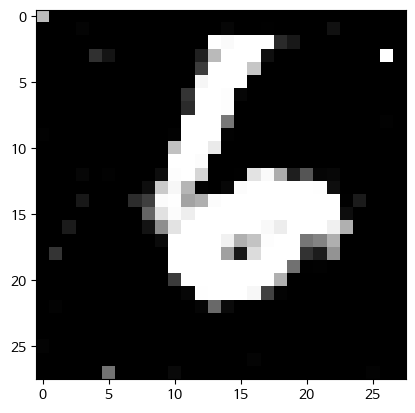

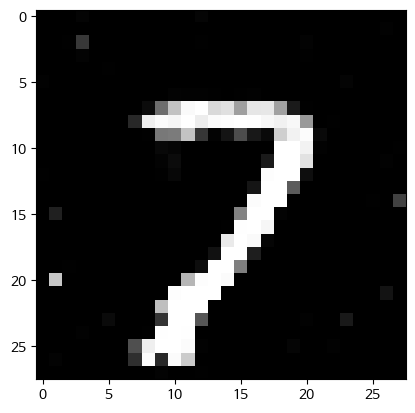

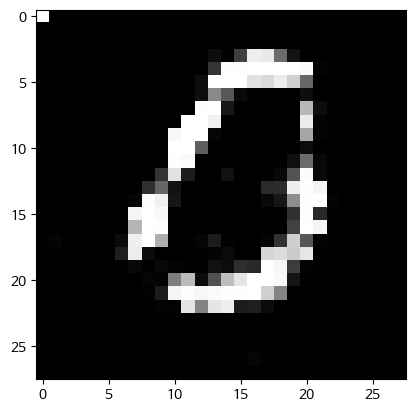

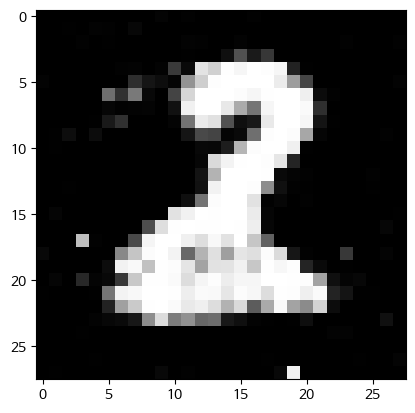

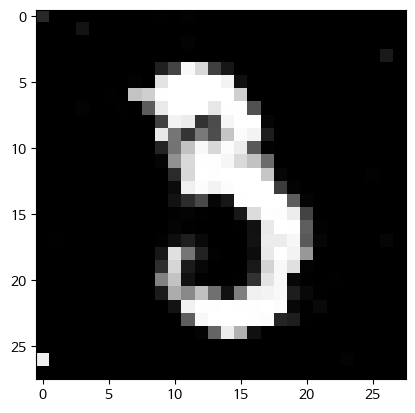

In [ ]:
# 생성 이미지 출력
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()